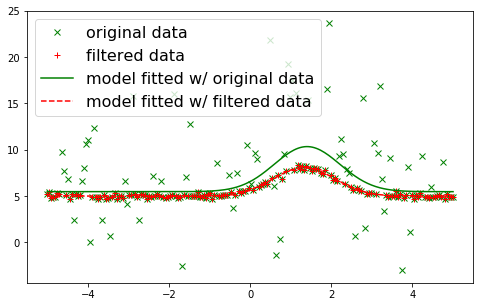

In [27]:
import numpy as np
from astropy.stats import sigma_clip
from astropy.modeling import models, fitting
import scipy.stats as stats
from matplotlib import pyplot as plt

# Generate fake data with outliers
np.random.seed(0)
x = np.linspace(-5., 5., 200)
y = 3 * np.exp(-0.5 * (x - 1.3)**2 / 0.8**2) + 5
c = stats.bernoulli.rvs(0.35, size=x.shape)
y += (np.random.normal(0., 0.2, x.shape) +
      c*np.random.normal(3.0, 5.0, x.shape))
g_init = models.Gaussian1D(amplitude=1., mean=0, stddev=1.) + models.Const1D()

# initialize fitters
fit = fitting.LevMarLSQFitter()
or_fit = fitting.FittingWithOutlierRemoval(fit, sigma_clip,
                                           niter=3, sigma=3.0)

# get fitted model and filtered data
filtered_data, or_fitted_model = or_fit(g_init, x, y)
fitted_model = fit(g_init, x, y)

# plot data and fitted models
plt.figure(figsize=(8,5))
plt.plot(x, y, 'gx', label="original data")
plt.plot(x, filtered_data, 'r+', label="filtered data")
plt.plot(x, fitted_model(x), 'g-',
         label="model fitted w/ original data")
plt.plot(x, or_fitted_model(x), 'r--',
         label="model fitted w/ filtered data")
plt.legend(loc=2, numpoints=1)